<a href="https://colab.research.google.com/github/mcnica89/Markov-Chains-RL-W25/blob/main/Bandit_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Multiarmed Bandit Simulator

In [ ]:
N_arms = 20 #number of arms avaialable
N_plays = 1000 #number of plays for each run
N_parr = 1000 #number rounds played in paralle

## Functions defining the arms and the choices

In [ ]:
def Gaussian_arms():
  '''Returns an array of shape (N_arms, N_parr) with the draws for that round and an array '''
  #Input: Nothing!
  #Output: A tuple
  #  random_draws = shape (N_arms,N_parr) with the draws that round
  #  regret = shape(N_arms,) with the regret for each of those choices

  #In this simulator the arms are all Gaussian with different means

  #Array with their means
  Arm_Means = np.zeros(N_arms)
  Arm_Means[0] = 1.0

  #Sample the values from a Gaussian
  arm_values = np.random.randn(N_arms,N_parr) + Arm_Means[:,np.newaxis]
  arm_regrets = np.max(Arm_Means) - Arm_Means
  return arm_values, arm_regrets

def random_choice(N, Avg):
  '''Given the information on the number of times we've played each arm and the running averages, make a choice'''
  #Input:
  #  N = an array of shape (N_arms,N_parr) with the number of times each arm has been played so far
  #  Avg = an array of shape (N_arms,N_parr) with the running average so far
  #Output:
  #  An array of shape (N_parr,) with the choice index in [0,N_arms) you want to play
  return np.random.randint(0,N_arms,N_parr)

def pure_greedy(N, Avg):
  '''Given the information on the number of times we've played each arm and the running averages, make a choice'''
  #Input:
  #  N = an array of shape (N_arms,N_parr) with the number of times each arm has been played so far
  #  Avg = an array of shape (N_arms,N_parr) with the running average so far
  #Output:
  #  An array of shape (N_parr,) with the choice index in [0,N_arms) you want to play
  t = np.sum(N,axis=0)[0] #the current time

  greedy_choices = np.argmax(Avg, axis=0) #After that go greedy
  if t < N_arms:
    return int(t)*np.ones(N_parr,dtype=int) #In the first N_arm rounds play each arm once
  else:
    return greedy_choices

## Main simulator

In [ ]:
def multiarmedbandit_simulator(arm_generator, choice_function,*,verbose=False):
  #Simulates the multiarmed bandits
  Arm_N = np.zeros((N_arms,N_parr)) #Number of times each arm has been played so far
  Arm_Avg = np.zeros((N_arms,N_parr)) #Running average of each arm
  Regret = np.zeros(N_plays) #Average Regret experienced for each choice

  for t in range(N_plays): #Main loop over time to play

    if verbose: print("t: ", t)

    choices = choice_function(Arm_N,Arm_Avg) #Get choices from choice_function
    if verbose: print("choices: ", choices)

    arm_values, arm_regrets = arm_generator() #Get arm values and regret from generator

    #Use choices to get the value we observe and regret
    value_observed = arm_values[choices,np.arange(N_parr)]
    regret_observed = arm_regrets[choices]

    if verbose: print("value_observed: ", value_observed)

    #Update number of times each arm is played and the average
    Arm_N[choices,np.arange(N_parr)] += 1
    Arm_Avg[choices,np.arange(N_parr)] += (value_observed-Arm_Avg[choices,np.arange(N_parr)])*(1/Arm_N[choices,np.arange(N_parr)])

    if verbose: print("Arm_N: \n", Arm_N)
    if verbose: print("Arm_Avg: \n", Arm_Avg)

    Regret[t] = np.mean(regret_observed)
    if verbose: print("Regret[t]", Regret[t])

  return Regret

def plot_regret(my_label, Regret):
  plt.grid(visible=True)
  plt.title("Average Regret ( N_parr: "+str(N_parr)+" N_arms: "+str(N_arms)+" )")
  plt.xlabel("Time")
  plt.ylabel("Cumulative Regret")
  plt.plot(np.cumsum(Regret), label = my_label)
  plt.legend()


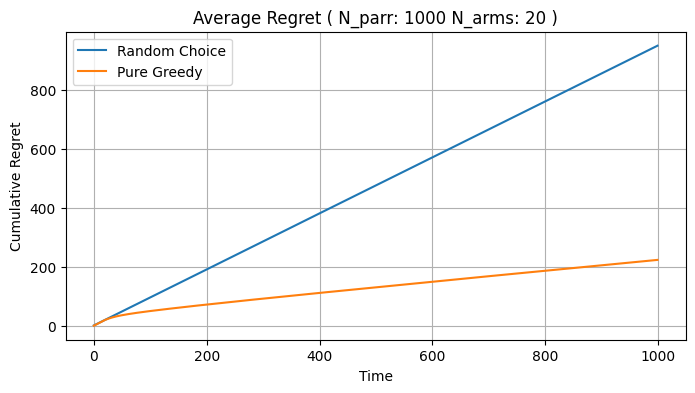

In [ ]:
plt.figure(figsize=(8,4))
plot_regret("Random Choice", multiarmedbandit_simulator(Gaussian_arms,random_choice))
plot_regret("Pure Greedy", multiarmedbandit_simulator(Gaussian_arms,pure_greedy))

# Explore then exploit



IN these algorithms we try all the arms $n$ times each, and then go greedy after that

In [ ]:
def explore_then_exploit(N, Avg, *, n=100):
  '''Given the information on the number of times we've played each arm and the running averages, make a choice'''
  #Input:
  #  N = an array of shape (N_arms,N_parr) with the number of times each arm has been played so far
  #  Avg = an array of shape (N_arms,N_parr) with the running average so far
  #Output:
  #  An array of shape (N_parr,) with the choice index in [0,N_arms) you want to play
  t = np.sum(N,axis=0)[0] #the current time
  if t < n:
    return int(t%N_arms)*np.ones(N_parr,dtype=int)
  else:
    greedy_choices = np.argmax(Avg, axis=0)
    return greedy_choices

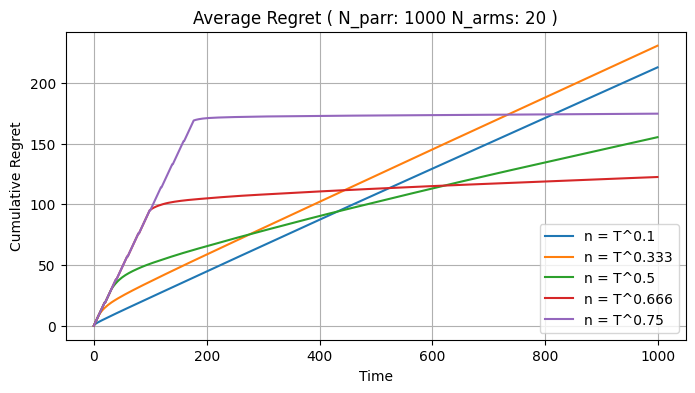

In [ ]:
#my_eps_greedy = lambda x,y : epsilon_greedy(x,y,epsilon=0.1)
#plot_regret("Epsilon = 0.1", multiarmedbandit_simulator(Gaussian_arms,my_eps_greedy))
plt.figure(figsize=(8,4))
for pow in [0.1, 0.333, 0.5, 0.666, 0.75]:
  n = N_plays**pow
  my_strat = lambda x,y: explore_then_exploit(x,y,n=n)
  plot_regret("n = T^"+str(pow), multiarmedbandit_simulator(Gaussian_arms,my_strat))

# Epsilon Greedy Algorithms

In these algorithms we go greedy except for with probability $\epsilon$ we choose randomly.

In [ ]:
def epsilon_greedy(N, Avg, *, epsilon=0.05):
  '''Given the information on the number of times we've played each arm and the running averages, make a choice'''
  #Input:
  #  N = an array of shape (N_arms,N_parr) with the number of times each arm has been played so far
  #  Avg = an array of shape (N_arms,N_parr) with the running average so far
  #Output:
  #  An array of shape (N_parr,) with the choice index in [0,N_arms) you want to play
  random_choices = np.random.randint(0,N_arms,N_parr)
  greedy_choices = np.argmax(Avg, axis=0)
  epsilon_event = np.random.binomial(1, epsilon, (N_parr) )

  return greedy_choices*(1-epsilon_event) + random_choices*epsilon_event

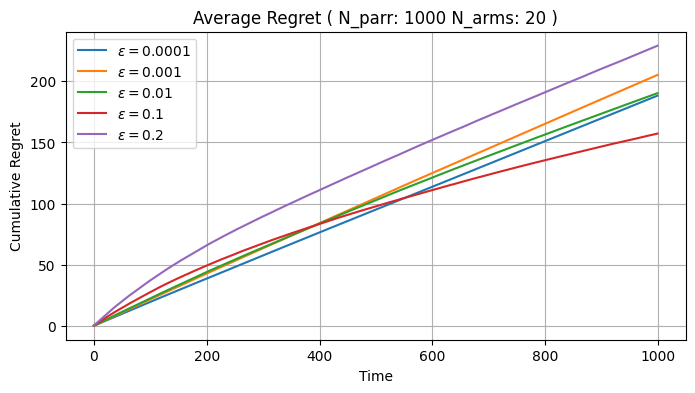

In [ ]:
plt.figure(figsize=(8,4))
for eps in [0.0001, 0.001, 0.01, 0.1, 0.2]:
  my_eps_greedy = lambda x,y: epsilon_greedy(x,y,epsilon=eps)
  plot_regret("$\epsilon ="+str(eps)+"$", multiarmedbandit_simulator(Gaussian_arms,my_eps_greedy))

# Epsilon Greedy According to a Power
$$\epsilon = \frac{1}{t^p}$$
for some power $p$

In [ ]:
def epsilon_pow(N, Avg, *, pow=0.33, a=0.25):
  '''Given the information on the number of times we've played each arm and the running averages, make a choice'''
  #Input:
  #  N = an array of shape (N_arms,N_parr) with the number of times each arm has been played so far
  #  Avg = an array of shape (N_arms,N_parr) with the running average so far
  #Output:
  #  An array of shape (N_parr,) with the choice index in [0,N_arms) you want to play
  t = np.sum(N,axis=0)[0] #the current time
  epsilon = min(1.0,a/(t+1)**pow)
  random_choices = np.random.randint(0,N_arms,N_parr)
  greedy_choices = np.argmax(Avg, axis=0)
  epsilon_event = np.random.binomial(1, epsilon, (N_parr) )

  return greedy_choices*(1-epsilon_event) + random_choices*epsilon_event

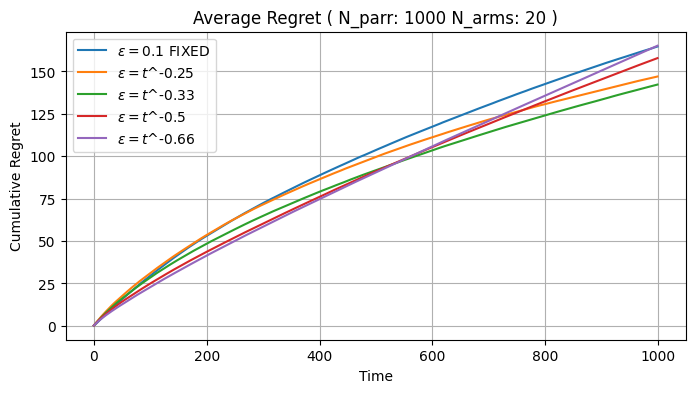

In [ ]:
plt.figure(figsize=(8,4))
my_eps_greedy = lambda x,y : epsilon_greedy(x,y,epsilon=0.1)
plot_regret("$\epsilon = 0.1$ FIXED", multiarmedbandit_simulator(Gaussian_arms,my_eps_greedy))
for pow in [0.25, 0.33, 0.5, 0.66]:
  my_eps_pow = lambda x,y: epsilon_pow(x,y,pow=pow)
  plot_regret("$\epsilon = t$"+"^-"+str(pow), multiarmedbandit_simulator(Gaussian_arms,my_eps_pow))

# UCB Algorithms

In [ ]:
def UCB(N, Avg, *, c=0.5):
  '''Given the information on the number of times we've played each arm and the running averages, make a choice'''
  #Input:
  #  N = an array of shape (N_arms,N_parr) with the number of times each arm has been played so far
  #  Avg = an array of shape (N_arms,N_parr) with the running average so far
  #Output:
  #  An array of shape (N_parr,) with the choice index in [0,N_arms) you want to play
  t = np.sum(N,axis=0)[0] #the current time
  if t < N_arms:
    return int(t)*np.ones(N_parr,dtype=int) #In the first N_arm rounds play each arm once

  UCB = Avg + c/np.sqrt(N)
  choices = np.argmax(UCB, axis=0)
  return choices

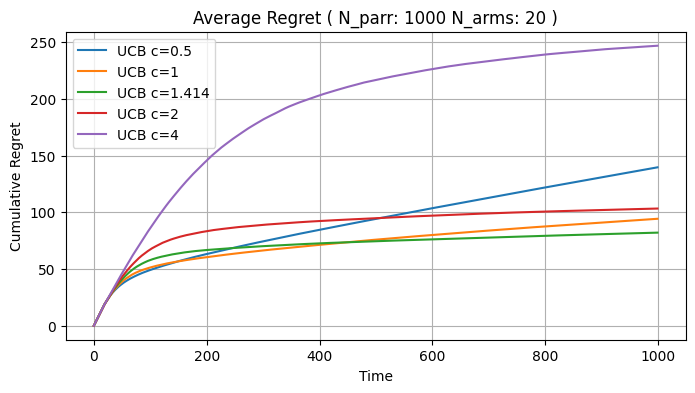

In [ ]:
#my_eps_greedy = lambda x,y : epsilon_greedy(x,y,epsilon=0.1)
#plot_regret("Epsilon = 0.1", multiarmedbandit_simulator(Gaussian_arms,my_eps_greedy))
#my_eps_pow = lambda x,y: epsilon_pow(x,y,pow=0.5)
#plot_regret("Epsilon Power=0.5", multiarmedbandit_simulator(Gaussian_arms,my_eps_pow))


plt.figure(figsize=(8,4))
for c in [0.5, 1, 1.414, 2,4]:
  my_UCB = lambda x,y: UCB(x,y,c=c)
  plot_regret("UCB c="+str(c), multiarmedbandit_simulator(Gaussian_arms,my_UCB))